In [1]:
import torch
import torch.nn as nn
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm import tqdm
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from skimage.transform import resize
from torch.utils.data import DataLoader
import cv2
import tqdm.notebook as tq
from torchvision import transforms
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageOps
import PIL
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle
from torchvision.utils import save_image

In [2]:
def save_some_examples(gen, val_loader, epoch, folder):
    X, y = next(iter(val_loader))
    X, y = X.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(X)
        y_fake = y_fake * 0.5 + 0.5 # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(X * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image (y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [3]:
def get_example(image):
    gen.eval()
    with torch.no_grad():
        res = gen(image[None].to(device))
        res = res * 0.5 + 0.5 # remove normalization#
    res = np.rollaxis(res[0].cpu().detach().numpy(), 0, 3)
    gen.train()
    return res
    

In [4]:
def show_example(test_loader, gen):
    gen.eval()
    sketch, img = next(iter(test_loader))
    with torch.no_grad():
        res = gen(sketch.to(device))
        res = res * 0.5 + 0.5 # remove normalization#
    res = np.rollaxis(res[0].cpu().detach().numpy(), 0, 3)
    gen.train()
    
    plt.subplot(1, 3, 1)
    plt.title("Sketch Image")
    plt.imshow(np.rollaxis((sketch[0]*0.5+0.5).cpu().detach().numpy(), 0, 3))
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Target Image")
    plt.imshow(np.rollaxis((img[0]*0.5+0.5).cpu().detach().numpy(), 0, 3))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Image")
    plt.imshow(res)
    plt.axis('off')
    
    plt.show()
    

In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.conv(x)

In [6]:
class Descriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )
        self.model = nn.Sequential(
            CNNBlock(64, 128, stride=2),
            CNNBlock(128, 256, stride=2),
            CNNBlock(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')
        )
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [7]:
class GenBlock(nn.Module):
    def __init__(self, in_features, out_features, stride=2, down=True, activation='relu', dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_features, out_features, 4, stride, 1, bias=False, padding_mode='reflect') 
            if down else nn.ConvTranspose2d(in_features, out_features, 4, stride, 1, bias=False),
            nn.InstanceNorm2d(out_features, affine=True),
            nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        )
        self.use_dropout = dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return x if not self.use_dropout else self.dropout(x)

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, bias=False, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        ) #128
        
        self.down2 = GenBlock(features, 2*features, down=True, activation='leaky', dropout=False) #64
        self.down3 = GenBlock(2*features, 2*features, down=True, activation='leaky', dropout=False) #32
        self.down4 = GenBlock(2*features, 4*features, down=True, activation='leaky', dropout=False) #16
        self.down5 = GenBlock(4*features, 4*features, down=True, activation='leaky', dropout=False) #8
        self.down6 = GenBlock(4*features, 8*features, down=True, activation='leaky', dropout=False) #4
        self.down7 = GenBlock(8*features, 8*features, down=True, activation='leaky', dropout=False) #2

        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*features, 16*features, kernel_size=1, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16*features, 8*features, kernel_size=1, stride=2, padding=1),
            nn.ReLU()
        )

        self.up1 = GenBlock(2*8*features, 8*features, down=False, activation='relu', dropout=True) #4
        self.up2 = GenBlock(2*8*features, 4*features, down=False, activation='relu', dropout=True) #8
        self.up3 = GenBlock(2*4*features, 4*features, down=False, activation='relu', dropout=True) #16
        self.up4 = GenBlock(2*4*features, 2*features, down=False, activation='relu', dropout=True) #32
        self.up5 = GenBlock(2*2*features, 2*features, down=False, activation='relu', dropout=True) #64
        self.up6 = GenBlock(2*2*features, features, down=False, activation='relu', dropout=True) #128
        self.up7 = nn.Sequential(
            nn.ConvTranspose2d(2*features, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ) #256

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        bn = self.bottleneck(d7)

        u1 = self.up1(torch.cat([bn, d7], dim=1))
        u2 = self.up2(torch.cat([u1, d6], dim=1))
        u3 = self.up3(torch.cat([u2, d5], dim=1))
        u4 = self.up4(torch.cat([u3, d4], dim=1))
        u5 = self.up5(torch.cat([u4, d3], dim=1))
        u6 = self.up6(torch.cat([u5, d2], dim=1))
        u7 = self.up7(torch.cat([u6, d1], dim=1))
        return u7


In [9]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [10]:

train_dir = "/kaggle/input/anime-sketch-colorization-pair/data/train"
val_dir = "/kaggle/input/anime-sketch-colorization-pair/data/val"
size = (256, 256)

batch_size = 4

train_img_paths = [
        os.path.join(train_dir, fname)
        for fname in sorted_alphanumeric(os.listdir(train_dir))
        if fname.endswith(".png")
    ]

test_img_paths = [
        os.path.join(val_dir, fname)
        for fname in sorted_alphanumeric(os.listdir(val_dir))
        if fname.endswith(".png")
    ]
print()

print("Number of train:", len(train_img_paths))
print("Number of test:", len(test_img_paths))




Number of train: 14224
Number of test: 3545


In [11]:
class AnimeSketchDataset(Dataset):
    def __init__(self,img_paths):
        super().__init__()
        self.img_paths = img_paths
        self.transform_both = A.Compose([A.Resize(256,256), A.HorizontalFlip()], additional_targets={"image0":"image"}) 
        self.transform_only_input = A.Compose([A.ColorJitter(p=0.1), A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
        self.transform_only_target = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = np.asarray(Image.open(self.img_paths[idx]))
        
        sketchs = image[:,image.shape[1]//2:,:]
        colored_imgs = image[:,:image.shape[1]//2,:]
        
        aug = self.transform_both(image=sketchs, image0=colored_imgs)
        sketch, img = self.transform_only_input(image=aug["image"])['image'], self.transform_only_target(image=aug["image0"])['image']
#         sketch = sketch / 127.5 - 1
#         img = img / 127.5 - 1

        
        return sketch, img

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
disc = Descriminator(in_channels=3).to(device)
gen = Generator(in_channels=3).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

In [14]:
gen.load_state_dict(torch.load('/kaggle/input/pix2pix-anime/results-9/gen.pt'))

<All keys matched successfully>

In [15]:
train_ds = AnimeSketchDataset(train_img_paths)
test_ds = AnimeSketchDataset(test_img_paths)


In [16]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [17]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [18]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    
    loop = tq.tqdm(loader, leave=True)
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    for idx, (x, y) in enumerate(loop) :
        x, y = x.to(device), y.to(device)
        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_fake = disc(x, y_fake.detach())
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        loss_d_per_epoch.append(D_loss.item())

        # Train Generator
        with torch.cuda.amp.autocast () :
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1(y_fake, y) * 100
            G_loss = G_fake_loss + L1  
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        loss_g_per_epoch.append(G_loss.item())
        
    return loss_g_per_epoch, loss_d_per_epoch

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 14.211699608474534 loss_d - 0.56637947384113


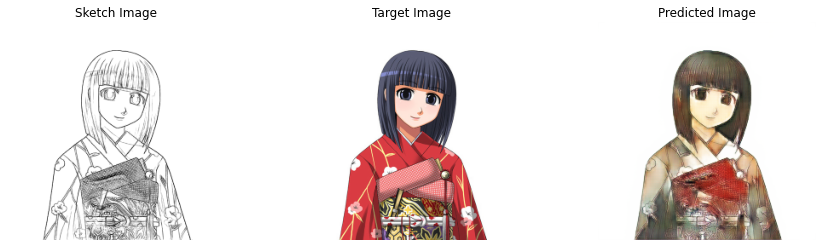

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 14.405556541191848 loss_d - 0.5264738797743389


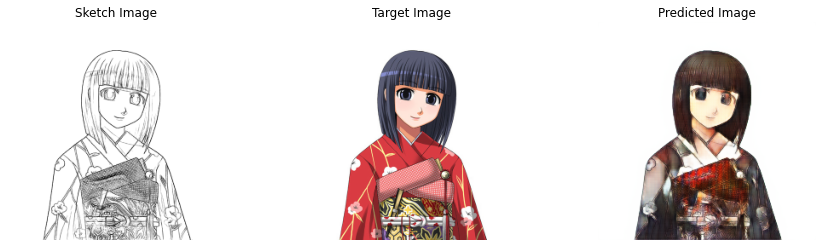

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 14.616035765684362 loss_d - 0.4765657452579391


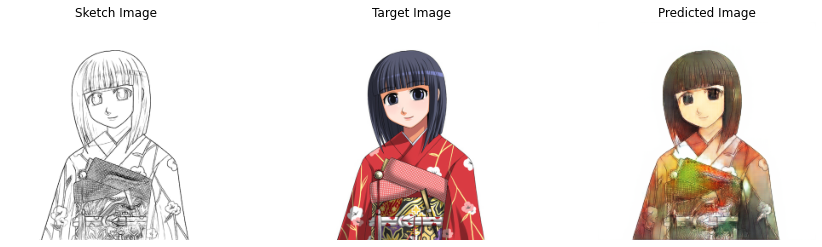

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 14.865926196926491 loss_d - 0.4182756948143378


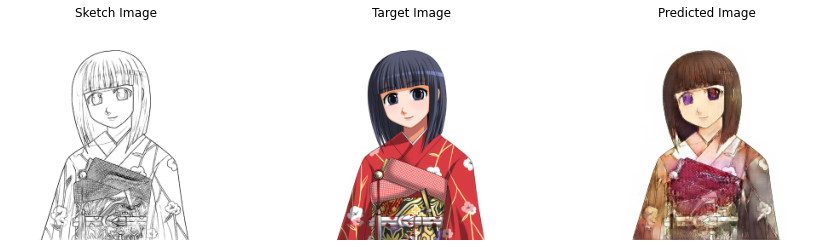

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 15.277257515957707 loss_d - 0.36046251227725107


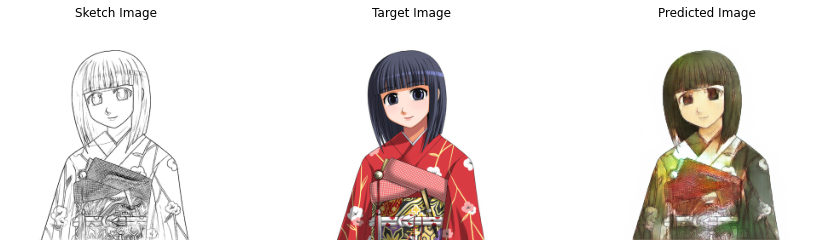

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 15.798650742783991 loss_d - 0.29459843403398905


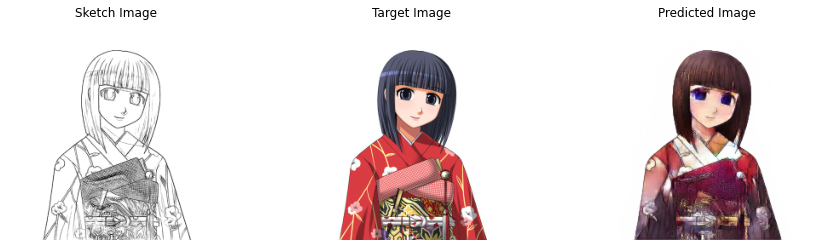

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 16.42685800354982 loss_d - 0.23265623630137633


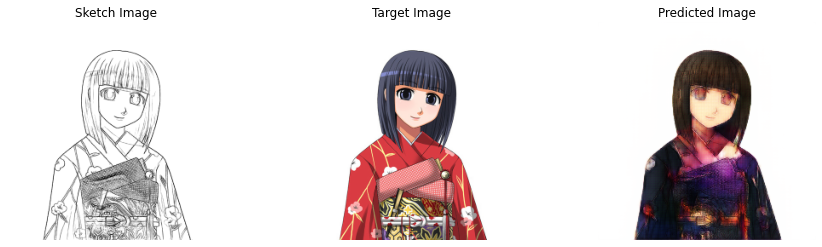

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 16.940625642630597 loss_d - 0.19275537112867094


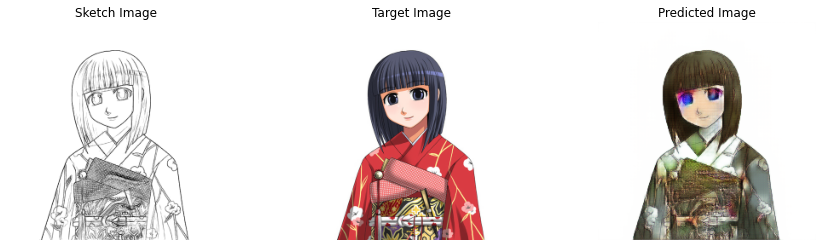

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 17.471162937355256 loss_d - 0.16149803511253627


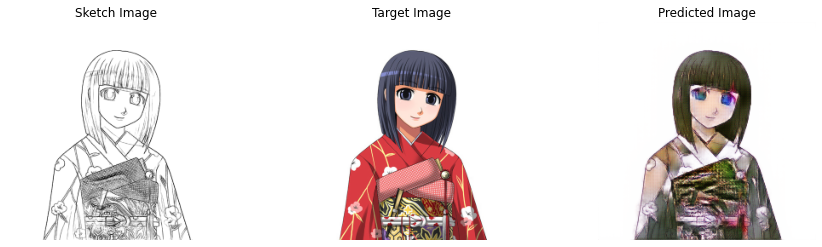

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 17.963423055792553 loss_d - 0.14416104128786716


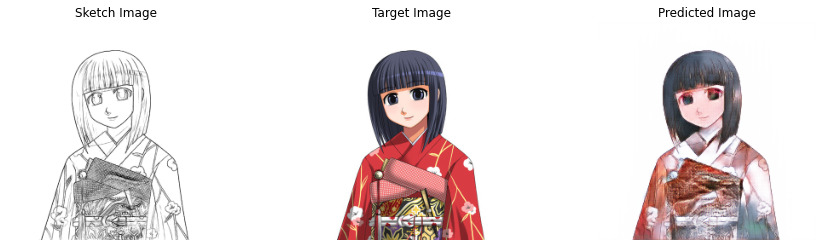

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 18.193115478693702 loss_d - 0.1295269705267823


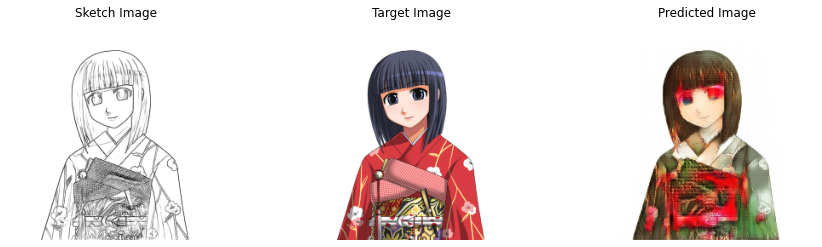

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 18.426660603157448 loss_d - 0.11993202872314261


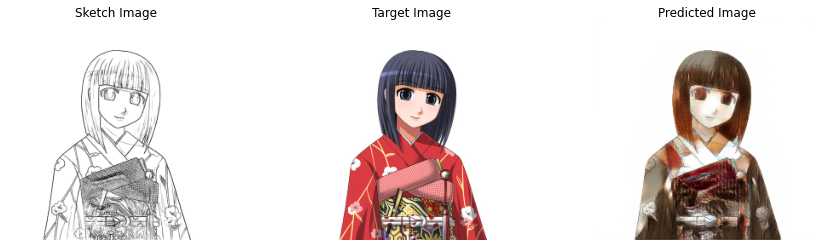

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 18.68678303483635 loss_d - 0.1069793774924386


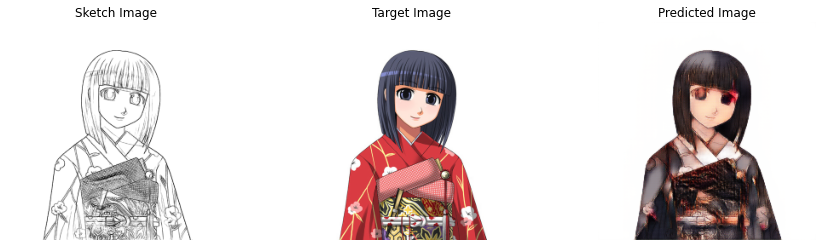

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 18.90352902825423 loss_d - 0.10067540102554692


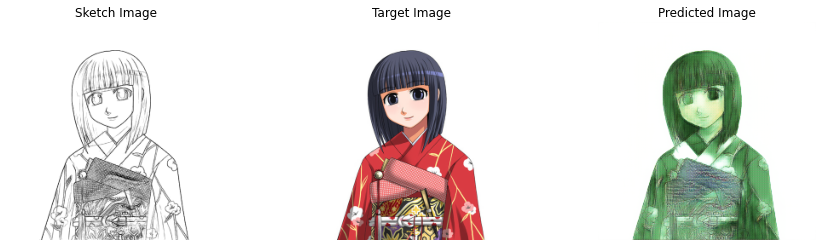

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 19.17030743458408 loss_d - 0.0905815110502693


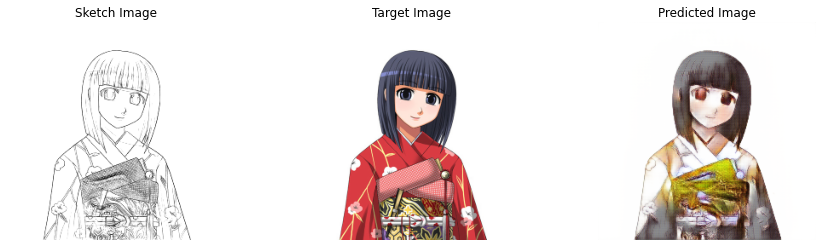

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 19.35022335889235 loss_d - 0.08097834992604865


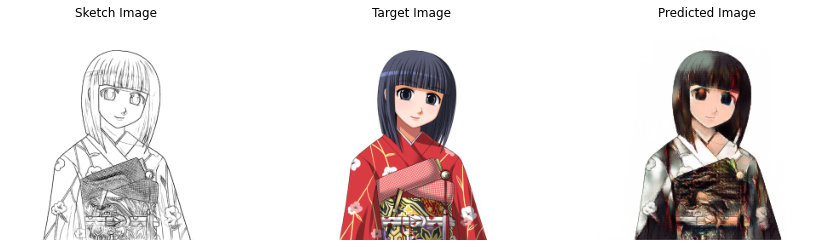

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 19.69956402220796 loss_d - 0.07909043964423623


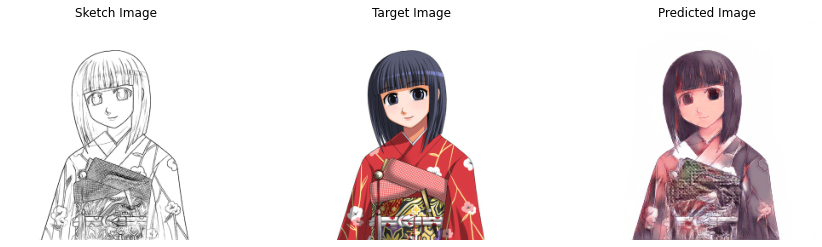

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 19.812013097233123 loss_d - 0.0725554833623328


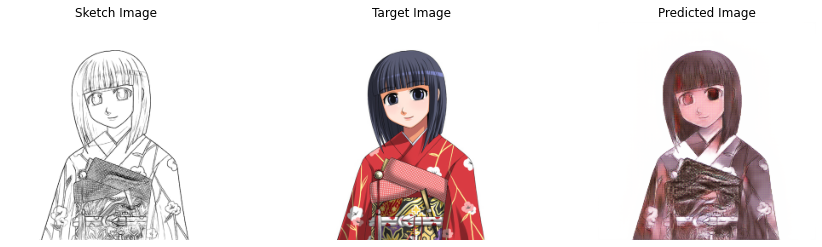

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 19.761470706712274 loss_d - 0.08295202404369324


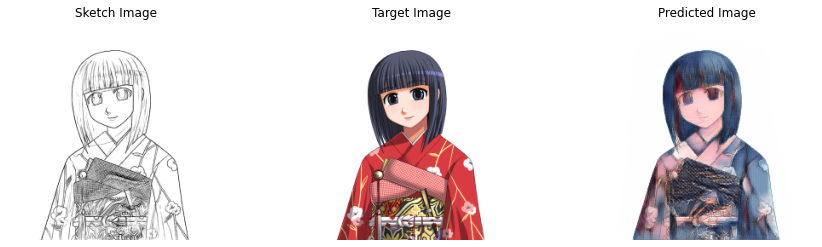

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.067318113635977 loss_d - 0.06487981552118327


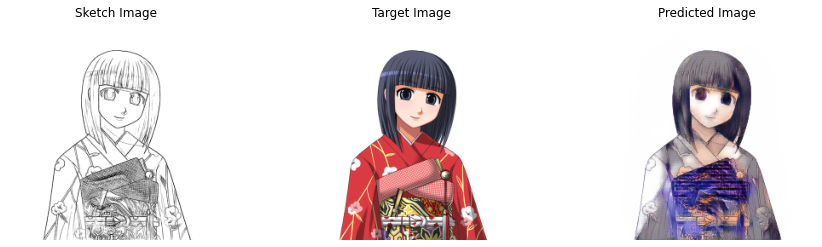

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.190003967124245 loss_d - 0.06417516200322451


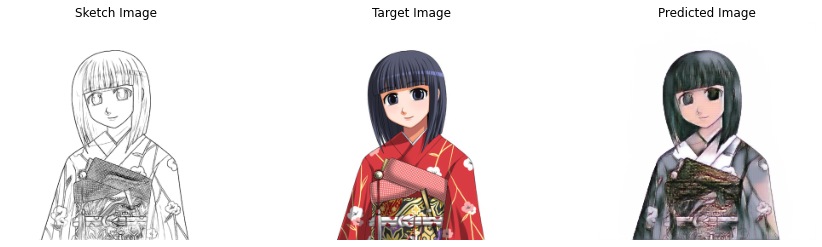

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.557830659021008 loss_d - 0.055163389886688494


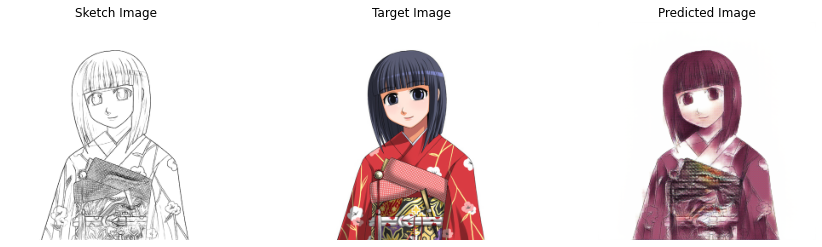

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.686992552202653 loss_d - 0.058520011325054216


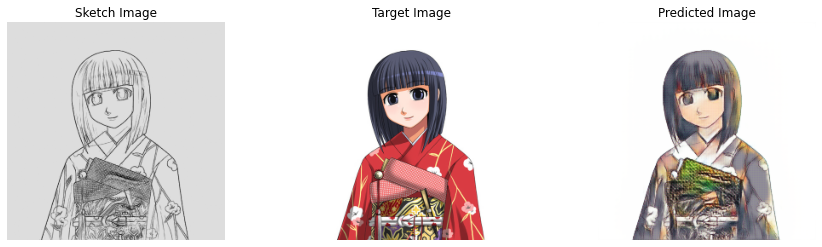

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.706215583299223 loss_d - 0.056756633246087915


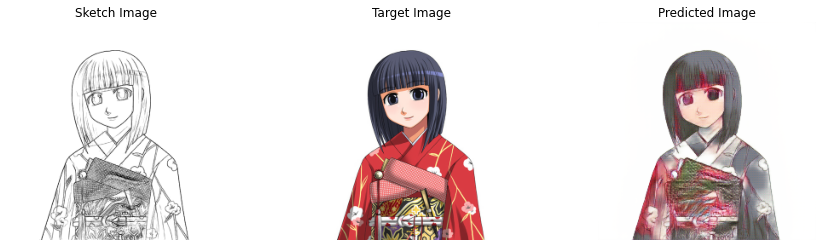

  0%|          | 0/3556 [00:00<?, ?it/s]

loss_g - 20.866558914645854 loss_d - 0.053326572609063864


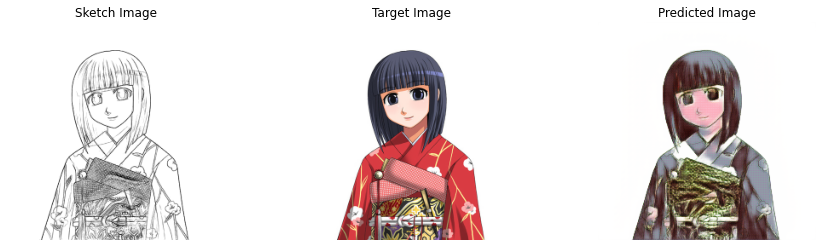

In [19]:
losses_g = []
losses_d = []
os.mkdir('evaluation')
for epoch in range(25):
    
    loss_g_per_epoch, loss_d_per_epoch = train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    print(f'loss_g - {losses_g[-1]} loss_d - {losses_d[-1]}')
    if epoch % 5 == 0: 
        torch.save(gen.state_dict(), 'gen.pt')
        torch.save(disc.state_dict(), 'disc.pt')
    save_some_examples(gen, test_loader, epoch, folder="/kaggle/working/evaluation")
    show_example(test_loader, gen)

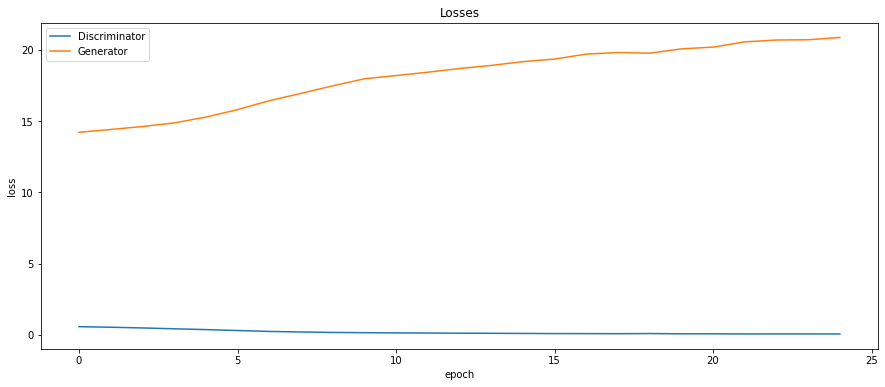

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');